In [1]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#stationarity test
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

import time

#time-series prediction models

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#trend analysis
from sklearn.linear_model import LinearRegression

#to generate all combinations of the parameters
import itertools

#models' accuracy calculation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score

#to ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
def direction(price_tplusone, price_t):
    if price_tplusone > price_t :
        return 1
    return 0

In [43]:
def get_label_arr(price_arr):
    label_arr = [0]
    for i in range(1,len(price_arr)):
        label_arr.append(direction(price_arr[i],price_arr[i-1]))
    return  np.array(label_arr)

In [42]:
def accuracy_of_direction(y_predicted, label_test,price_test):                
                label_predicted = []            
                label_predicted.append(direction(y_predicted[0],price_test[0]))
                for index in range(1,len(y_predicted)):
                     label_predicted.append(direction(y_predicted[index], y_predicted[index-1]))
                    
                
                ts_acc_pca = accuracy_score(label_test,label_predicted)
                return ts_acc_pca

In [48]:
def save_results_to_csv(results, colnames, file_name_suffix ):
    results_df = pd.DataFrame(results,columns=colnames)
    fname=file_name_suffix+str(time.time())+'.csv'
    results_df.to_csv(fname)

In [22]:
df = pd.read_csv('data/DJIA_table.csv')
dfCombined = pd.read_csv('data/Combined_News_DJIA_Prices.csv')

In [23]:
df['DiffPrice'] = df['Close']-df['Open']

In [24]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,DiffPrice
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,25.128907
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,217.230468
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,238.660157
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,219.210937
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-214.970704


In [25]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close,DiffPrice
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000
mean,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,13463.032255,3.916206
std,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,3144.006996,141.227938
min,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805,-774.169922
25%,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,10913.379883,-60.169922
50%,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,13025.580078,8.540039
75%,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,16478.410156,74.558594
max,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625,925.190430


In [26]:
data = df
data = data.set_index('Date')
data = data.loc[:,'Close']

In [27]:
data.describe()

count     1989.000000
mean     13463.032255
std       3144.006996
min       6547.049805
25%      10913.379883
50%      13025.580078
75%      16478.410156
max      18312.390625
Name: Close, dtype: float64

Text(0.5, 1.0, 'Autocorrelation plot lag=5')

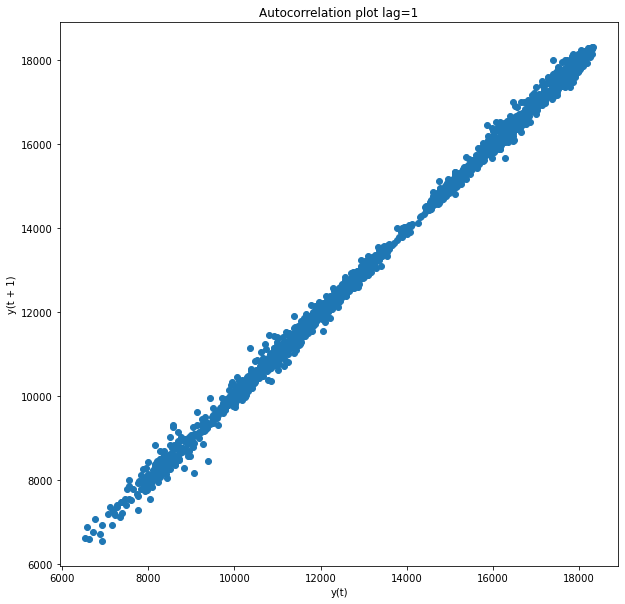

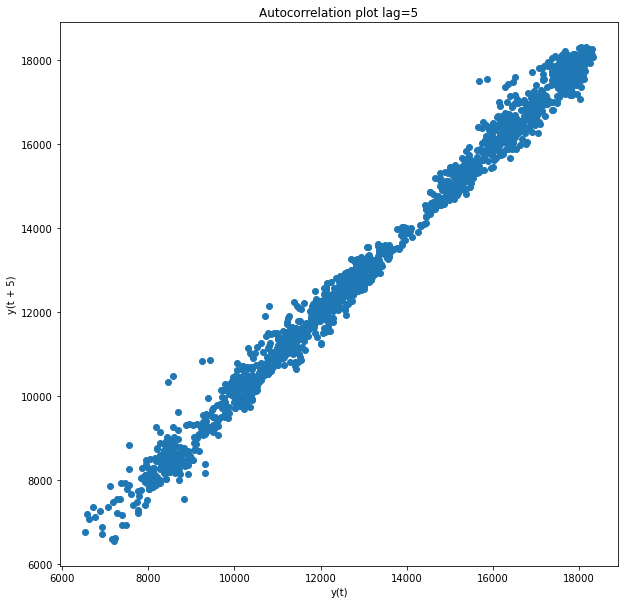

In [28]:
from pandas.plotting import lag_plot
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=1)
plt.title('Autocorrelation plot lag=1')

plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Autocorrelation plot lag=5')


In [29]:

import matplotlib.pyplot as plt

In [30]:
#stationarity test
from statsmodels.tsa.stattools import adfuller

In [31]:
result = adfuller(data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -1.226757785411685
p-value: 0.6619805931301762


In [32]:
data_price_diff = df
data_price_diff = data_price_diff.set_index('Date')
data_price_diff =  data_price_diff.loc[:,'DiffPrice']

Text(0.5, 1.0, 'Price movement in a day, stationary time series')

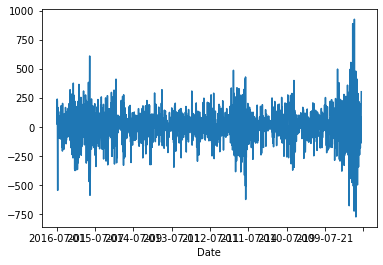

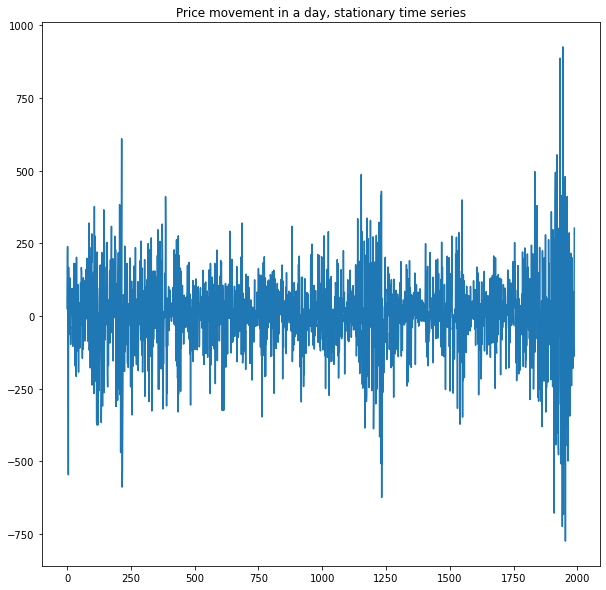

In [33]:
#Differencing
data_price_diff.plot()
plt.figure(figsize=(10,10))
plt.plot(data_price_diff.values)
plt.title('Price movement in a day, stationary time series')



In [34]:
result = adfuller(data_price_diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -10.090028744927771
p-value: 1.1285560565967265e-17


# AR Model

(1989,) (1989,)


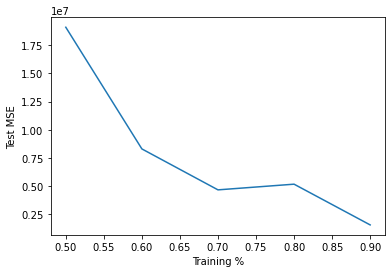

In [49]:
#plot the accuracy with various train-test splits

x = data.values
label_arr = get_label_arr(x)
print(x.shape,label_arr.shape)

train_per_list=[0.5,0.6,0.7,0.8,0.9]
acc_list=[]

for train_per in train_per_list:
    
    #perform the split
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]
    
    #train the model
    arma_model = ARIMA(train, order=(1, 0, 1))
    arma_fit = arma_model.fit()
    arma_pred = arma_fit.predict(start=int(x.size*train_per), end=x.size-1)
    
    #store the results
    acc_list.append(mean_squared_error(test, arma_pred))

#plot the graph
plt.plot(train_per_list,acc_list)
plt.ylabel('Test MSE')
plt.xlabel('Training %')
plt.show()

In [50]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x = np.array(data.values)
x = x.reshape(-1,1)
x = min_max_scaler.fit_transform(x)

In [ ]:
train_per_list=[0.6,0.7,0.8]
p = [1,5,7,10,12,15]
d = [0,1,3,5]
q = [1,5]

pdq = list(itertools.product(p,d,q))

acc_list = []

smallest_mse = 1000000000000000
best_acc = -1
best=[]
best_dir_acc=[]

for train_per in train_per_list:
    i=1
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]  
    label_test=label_arr[int(x.size*train_per):]
    for param in pdq:
        i+=1
        start=time.time()
        try:
            #train the model 
            arima_model = ARIMA(train, order=param)
            arima_fit = arima_model.fit()

            #record the predictions for calculating accuracy
            arima_pred = arima_fit.predict(start=int(x.size*train_per), end=x.size-1)
            acc=mean_squared_error(test, arima_pred)
            ts_acc_dir= accuracy_of_direction(arima_pred,label_test,test)

            #store the accrucy in a list for graph plotting
            acc_list.append([train_per,param,acc,ts_acc_dir])

            #capture the smallest MSE and its parameters
            #capture the best accuracy and its parameters
            if acc < smallest_mse:
                smallest_mse = acc
                best = [param, train_per]
            
            if ts_acc_dir > best_acc:
                best_acc = ts_acc_dir
                best_dir_acc = [param, train_per]
                
            total = time.time() - start    
            print("For ",train_per," executed : ",i,"/",len(pdq)," : ", param, "MSE ",acc,'Acc ',ts_acc_dir,'Time ',total)    

        except:
            #if the parameters are invalid, i.e. model training gives error, 
            #then add a very high error rate in the accrucy list
            print('Error in training model with param',param)
            acc_list.append([train_per,param,1])
            continue
        


print("\n\nsmallest mse is ", smallest_mse)
print("best parameters are ", best)
print("\n\nBest prediction accuracy is ", ts_acc_dir)
print("best parameters are ", best_dir_acc)

save_results_to_csv(acc_list,['Train_Per','Params','MSE','Accuracy'],'results_arima_accuracy')

For  0.6  executed :  2 / 48  :  (1, 0, 1) MSE  0.05260579173849632 Acc  0.45603015075376885 Time  0.2609527111053467
Error in training model with param (1, 0, 5)
For  0.6  executed :  4 / 48  :  (1, 1, 1) MSE  0.11719032930953378 Acc  0.5439698492462312 Time  0.5614140033721924
For  0.6  executed :  5 / 48  :  (1, 1, 5) MSE  0.11724656187056215 Acc  0.5439698492462312 Time  1.046382188796997
Error in training model with param (1, 3, 1)
Error in training model with param (1, 3, 5)
Error in training model with param (1, 5, 1)
Error in training model with param (1, 5, 5)
Error in training model with param (5, 0, 1)
Error in training model with param (5, 0, 5)
For  0.6  executed :  12 / 48  :  (5, 1, 1) MSE  0.11724768482252439 Acc  0.5552763819095478 Time  0.7350645065307617
For  0.6  executed :  13 / 48  :  (5, 1, 5) MSE  0.11713516497539513 Acc  0.49120603015075376 Time  23.803565979003906
Error in training model with param (5, 3, 1)
Error in training model with param (5, 3, 5)
Error i

,Train_Per,Params,Accuracy
0,0.6,"(1, 0, 1)",0.052606
1,0.6,"(1, 0, 5)",1.000000
2,0.6,"(1, 1, 1)",0.117190
3,0.6,"(1, 1, 5)",0.117247
4,0.6,"(1, 3, 1)",1.000000
...,...,...,...
139,0.8,"(15, 1, 5)",0.063391
140,0.8,"(15, 3, 1)",1.000000
141,0.8,"(15, 3, 5)",1.000000
142,0.8,"(15, 5, 1)",1.000000


In [ ]:
train_per_list=[0.6,0.7]
p = [1,5,10]
d = [0,1]
q = [5]

pdq = list(itertools.product(p,d,q))

acc_list_sarima = []
results_df_sarima = pd.DataFrame(acc_list_sarima,columns=['Train_Per','Params','Accuracy'])

smallest_mse = 1000000000000000
#train_per_list=[0.5,0.6,0.7,0.8]
best=[]
best_acc = -1
best_dir_acc=[]

for train_per in train_per_list:
    i=0
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]    
    label_test=label_arr[int(x.size*train_per):]
    for param in pdq:
            i+=1    
        try:
            start=time.time()
            print("For ",train_per," executing : ",i,"/",len(pdq)," : ", param)    
            seasonal_order = list(param)
            seasonal_order.append(12)

            #train the model 
            sarima_model = SARIMAX(train, order=param, seasonal_order=seasonal_order)
            sarima_fit = sarima_model.fit()


            #record the predictions for calculating accuracy
            sarima_pred = sarima_fit.forecast(test.shape[0])            
            acc=mean_squared_error(test, sarima_pred)
            ts_acc_dir= accuracy_of_direction(sarima_pred,label_test,test)

            #store the accrucy in a list for graph plotting
            acc_list_sarima.append([train_per,param,acc,ts_acc_dir])
            results_df_sarima = pd.DataFrame(acc_list_sarima,columns=['Train_Per','Params','MSE','Accuracy'])

            #capture the smallest MSE and its parameters
            if acc < smallest_mse:
                 smallest_mse = acc
                 best = [param, train_per]
            if ts_acc_dir > best_acc:
                best_acc = ts_acc_dir
                best_dir_acc = [param, train_per]    
            total = time.time() - start    
            print("For ",train_per," executed : ",i,"/",len(pdq)," : ", param, "MSE ",acc,'Accuracy ',ts_acc_dir, 'Time in secs ',total)    
        except:
             #if the parameters are invalid, i.e. model training gives error, 
            #then add a very high error rate in the accrucy list
            print('Error in training model with param',param)
            acc_list.append([train_per,param,1])
            continue
            
               
print("\n\nsmallest mse is ", smallest_mse)
print("best parameters are ", best)


print("\n\nBest prediction accuracy is ", ts_acc_dir)
print("best parameters are ", best_dir_acc)

save_results_to_csv(acc_list_sarima,['Train_Per','Params','MSE','Accuracy'],'results_sarima_accuracy')


In [ ]:
###Predictions
train_per=0.8
param=[15,0,5]
train = x[:int(x.size*train_per)]
test = x[int(x.size*train_per):]    
label_test=label_arr[int(x.size*train_per):]
try:
            #train the model 
            arima_model = ARIMA(train, order=param)
            arima_fit = arima_model.fit()

            #record the predictions for calculating accuracy
            arima_pred = arima_fit.predict(start=int(x.size*train_per), end=x.size-1)
            acc=mean_squared_error(test, arima_pred)
            print(accuracy_of_direction(arima_pred,label_test,test))

except:
            #if the parameters are invalid, i.e. model training gives error, 
            #then add a very high error rate in the accrucy list
            print('Error in training model with param',param)
            acc_list.append([train_per,param,1])
                    


